The purpose of this notebook is a basic exploration of the NSL-KDD dataset. Here are the goals of this exploration:

* Gain a basic understanding of the data set
* Look at how the data set might be used to predict network anomalies or attacks
* Walk through some fundemental concepts of building machine learning models like Logistic Regression and Decision Tree classifier
* Compare the performance of selected feature engineering techniques.

Importing libraries

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random

# model imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# processing imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Data extraction

In [2]:
# fetch the training file
file_path_train = './dataset/KDDTrain+.txt'
file_path_test = './dataset/KDDTest+.txt' 

df = pd.read_csv(file_path_train, header=None)
test_df = pd.read_csv(file_path_test, header=None)

df

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20


In [3]:
# add the column labels
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

df.columns = columns
test_df.columns = columns

# sanity check
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


Data transformation - The first transformations that we'll want to do are around the attack field. We'll start by adding a column that encodes 'normal' values as 0 and any other value as 1. We will use this as our classifier for a simple binary model that idenfities any attack.

In [4]:
# map normal to 0, all attacks to 1
is_attack = df.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = test_df.attack.map(lambda a: 0 if a == 'normal' else 1)

#data_with_attack = df.join(is_attack, rsuffix='_flag')
df['attack_flag'] = is_attack
test_df['attack_flag'] = test_attack

# view the result
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0


<AxesSubplot:>

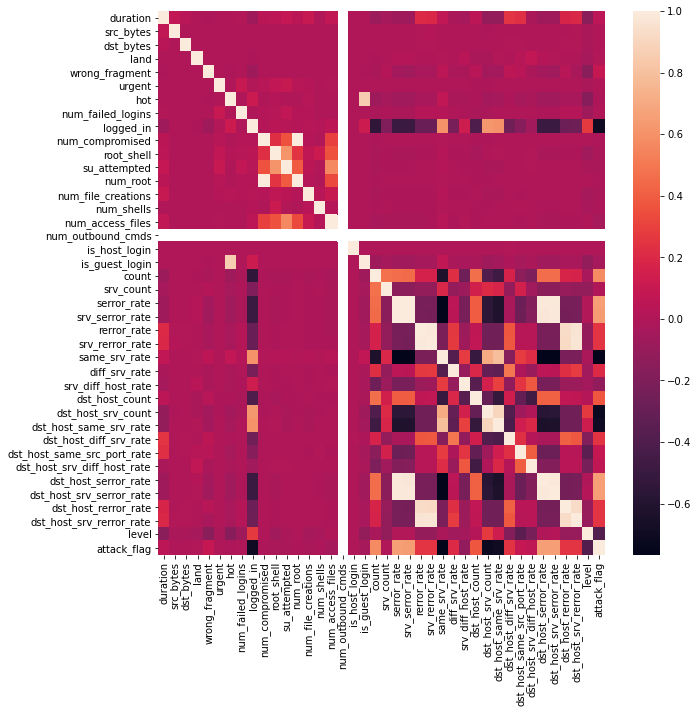

In [5]:
fig, ax = plt.subplots(figsize=(10,10)) 

var_corr = df.corr()
sns.heatmap(var_corr, xticklabels=var_corr.columns, yticklabels=var_corr.columns, ax=ax)

References from Research Papers-
http://45.113.122.54/pdfs/ijrscse/v2-i3/7.pdf - Attack cassifications for ML algos
https://lupinepublishers.com/computer-science-journal/fulltext/detecting-distributed-denial-of-service-ddos-attacks.ID.000110.php

In [6]:
df['attack'].unique()

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl'], dtype=object)

!! To avoid data leakage we should delete 'attack' column

In [7]:
df = df.drop('attack', 1)

In [8]:
# lists to hold our attack classifications
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
privilege_attacks = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
access_attacks = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']

# we will use these for plotting below
attack_labels = ['Normal','DoS','Probe','Privilege','Access']

In [9]:
# helper function to pass to data frame mapping
def map_attack(attack):
    if attack in dos_attacks:
        # dos_attacks map to 1
        attack_type = 1
    elif attack in probe_attacks:
        # probe_attacks mapt to 2
        attack_type = 2
    elif attack in privilege_attacks:
        # privilege escalation attacks map to 3
        attack_type = 3
    elif attack in access_attacks:
        # remote access attacks map to 4
        attack_type = 4
    else:
        # normal maps to 0
        attack_type = 0
        
    return attack_type

In [10]:
df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'level', 'attack_flag'],
      dtype='object')

In [12]:
# # map the data and join to the data set
# attack_map = df.attack.apply(map_attack)
# df['attack_map'] = attack_map

# test_attack_map = test_df.attack.apply(map_attack)
# test_df['attack_map'] = test_attack_map

In [13]:
# view the result
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level,attack_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20,0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21,0


Data profiling
First is a simple table of attack by protocol. In network traffic analysis protocol is a simple tool to create some initial buckets to categorize our data. 'normal' is left in the set at this point as a benchmark.

pd.crosstab - Compute a simple cross tabulation of two (or more) factors

In [14]:
# # use a crosstab to get attack vs protocol
# attack_vs_protocol = pd.crosstab(df.attack, df.protocol_type)
# attack_vs_protocol

In [15]:
# helper function for drawing mulitple charts.
def bake_pies(data_list,labels):
    list_length = len(data_list)
    
    # setup for mapping colors
    color_list = sns.color_palette()
    color_cycle = itertools.cycle(color_list)
    cdict = {}
    
    # build the subplots
    fig, axs = plt.subplots(1, list_length,figsize=(18,10), tight_layout=False)
    plt.subplots_adjust(wspace=1/list_length)
    
    # loop through the data sets and build the charts
    for count, data_set in enumerate(data_list): 
        
        # update our color mapt with new values
        for num, value in enumerate(np.unique(data_set.index)):
            if value not in cdict:
                cdict[value] = next(color_cycle)
       
        # build the wedges
        wedges,texts = axs[count].pie(data_set,
                           colors=[cdict[v] for v in data_set.index])
        # build the legend
        axs[count].legend(wedges, data_set.index,
                           title="Flags",
                           loc="center left",
                           bbox_to_anchor=(1, 0, 0.5, 1))
        # set the title
        axs[count].set_title(labels[count])
        
    return axs   

In [15]:
'''from mpl_toolkits.mplot3d import Axes3D

# set grid style
sns.set_style("whitegrid", {'axes.grid' : False})

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# set data
df = pd.read_csv("/kaggle/input/nslkdd/KDDTrain+.txt")
df.columns = columns
df = df.dropna()
print(df.shape)
df.head(15)
is_attack = df.attack.map(lambda a: 0 if a == 'normal' else 1)
df['attack_flag'] = is_attack
print("attack_flag", df.attack_flag)
XY = df.drop(df.columns[[2]], axis=1)
x = df.x
y = df.y
z = df.attack_flag

# plot
ax.scatter(x, y, z, c=x, marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()'''

'from mpl_toolkits.mplot3d import Axes3D\n\n# set grid style\nsns.set_style("whitegrid", {\'axes.grid\' : False})\n\n# axes instance\nfig = plt.figure(figsize=(6,6))\nax = Axes3D(fig)\n\n# set data\ndf = pd.read_csv("/kaggle/input/nslkdd/KDDTrain+.txt")\ndf.columns = columns\ndf = df.dropna()\nprint(df.shape)\ndf.head(15)\nis_attack = df.attack.map(lambda a: 0 if a == \'normal\' else 1)\ndf[\'attack_flag\'] = is_attack\nprint("attack_flag", df.attack_flag)\nXY = df.drop(df.columns[[2]], axis=1)\nx = df.x\ny = df.y\nz = df.attack_flag\n\n# plot\nax.scatter(x, y, z, c=x, marker=\'o\')\nax.set_xlabel(\'X Label\')\nax.set_ylabel(\'Y Label\')\nax.set_zlabel(\'Z Label\')\n\nplt.show()'

In [16]:
# # get the series for each protocol
# icmp_attacks = attack_vs_protocol.icmp
# tcp_attacks = attack_vs_protocol.tcp
# udp_attacks = attack_vs_protocol.udp

# # create the charts
# bake_pies([icmp_attacks, tcp_attacks, udp_attacks],['icmp','tcp','udp'])
# plt.show()

The thing to notice here is the difference in each protocol type. Our initial impression is that protocol may be useful in being able to identify the type of traffic we are observing. Let's see if flag behaves the same way.

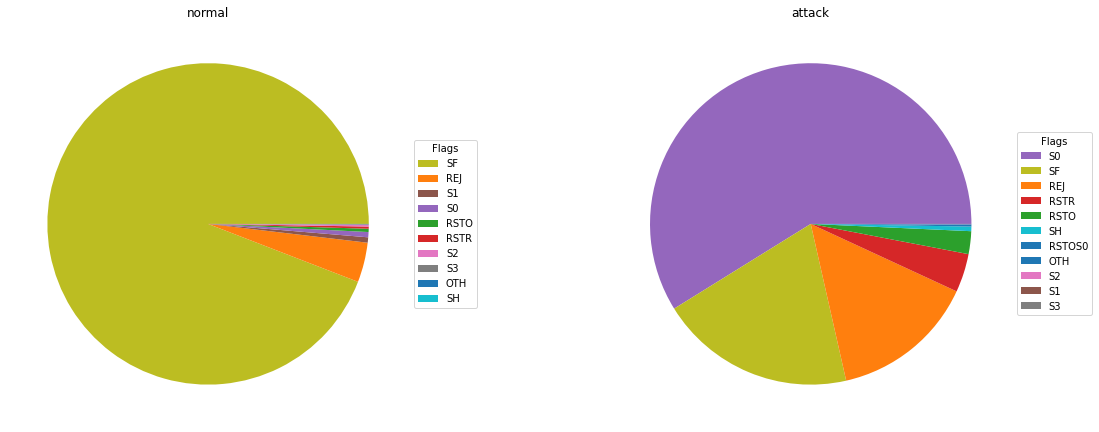

In [17]:
# get a series with the count of each flag for attack and normal traffic
normal_flags = df.loc[df.attack_flag == 0].flag.value_counts()
attack_flags = df.loc[df.attack_flag == 1].flag.value_counts()

# create the charts
flag_axs = bake_pies([normal_flags, attack_flags], ['normal','attack'])        
plt.show()

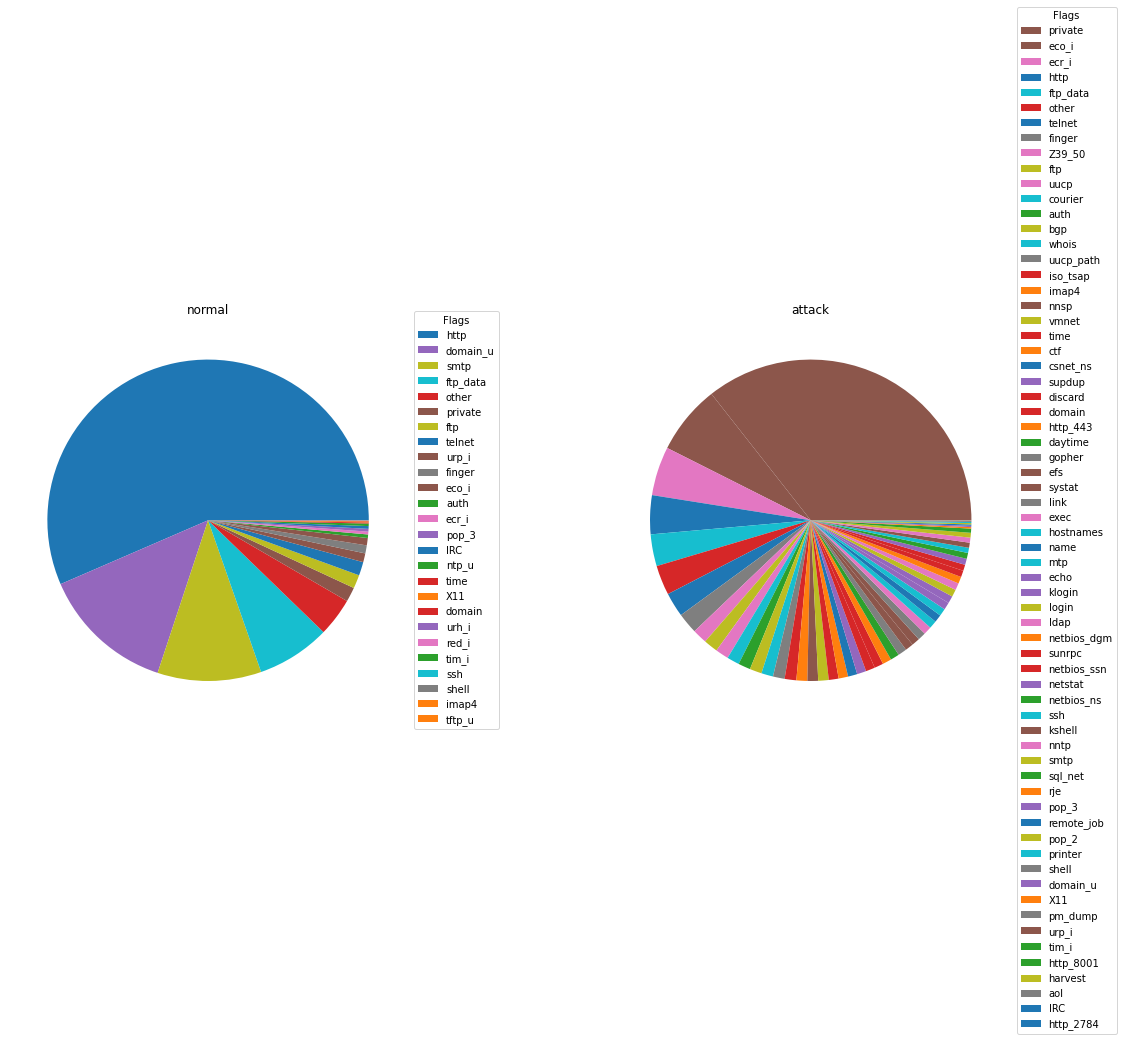

In [18]:
# get a series with the count of each service for attack and normal traffic
normal_services = df.loc[df.attack_flag == 0].service.value_counts()
attack_services = df.loc[df.attack_flag == 1].service.value_counts()

# create the charts
service_axs = bake_pies([normal_services, attack_services], ['normal','attack'])        
plt.show()

/home/beata/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='level', ylabel='Density'>

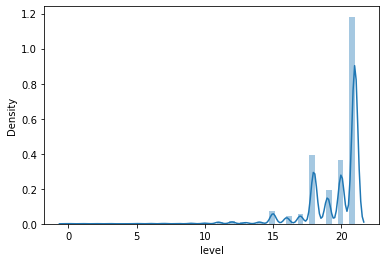

In [19]:
sns.distplot(df['level'])

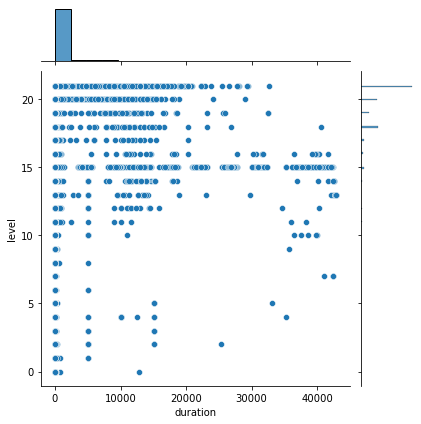

In [20]:
sns.jointplot(x='duration', y='level', data=df, kind='scatter')

Wow! Look at how many services are in the attack set! Whereas a huge amount of normal traffic is http, our attack traffic is all over the place.

Feature engineering - Label encoding. pd.get_dummies is a method that allows us to do a quick one hot encoding on our columns. This takes every value it finds in a single column and makes an individual column for each value, with a 0 or 1 indicating whether that column is 'hot'.
We're also going to throw in some basic numeric data: duration, src_bytes, dst_bytes.

In [21]:
# get the intial set of encoded features and encode them
features_to_encode = ['protocol_type', 'service', 'flag']
encoded = pd.get_dummies(df[features_to_encode])
test_encoded_base = pd.get_dummies(test_df[features_to_encode])

# not all of the features are in the test set, so we need to account for diffs
test_index = np.arange(len(test_df.index))
column_diffs = list(set(encoded.columns.values)-set(test_encoded_base.columns.values))

diff_df = pd.DataFrame(0, index=test_index, columns=column_diffs)

# we'll also need to reorder the columns to match, so let's get those
column_order = encoded.columns.to_list()

# append the new columns
test_encoded_temp = test_encoded_base.join(diff_df)

# reorder the columns
test_final = test_encoded_temp[column_order].fillna(0)

# get numeric features, we won't worry about encoding these at this point
numeric_features = ['duration', 'src_bytes', 'dst_bytes']

# model to fit/test
to_fit = encoded.join(df[numeric_features])
test_set = test_final.join(test_df[numeric_features])

In [22]:
len(to_fit)

125972

In [23]:
to_fit.head()

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,duration,src_bytes,dst_bytes
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,146,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,232,8153
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,199,420
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
df['attack_flag'].head()

0    0
1    1
2    0
3    0
4    1
Name: attack_flag, dtype: int64

In [25]:
result = pd.concat([to_fit, df['attack_flag']], axis=1)
result.head()

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,duration,src_bytes,dst_bytes,attack_flag
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,146,0,0
1,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,232,8153,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,199,420,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [27]:
result.to_csv("initdf.csv")

In [24]:
# # create our target classifications
# binary_y = df['attack_flag']
# multi_y = df['attack_map']

# test_binary_y = test_df['attack_flag']
# test_multi_y = test_df['attack_map']

# # build the training sets
# binary_train_X, binary_val_X, binary_train_y, binary_val_y = train_test_split(to_fit, binary_y, test_size=0.6)
# multi_train_X, multi_val_X, multi_train_y, multi_val_y = train_test_split(to_fit, multi_y, test_size = 0.6)

Machine Learning model fitting

In [26]:
# #Decision Tree
# clf = DecisionTreeClassifier() #max_depth=10
# clf = clf.fit(binary_train_X, binary_train_y)
# clf_predictions = clf.predict(binary_val_X) # make prediction
# train_acc = clf.score(binary_train_X, binary_train_y) # mean acc on train data
# base_clf_score = accuracy_score(clf_predictions,binary_val_y) # mean acc on test data
# print("Training accuracy is:", train_acc )
# print("Testing accuracy is:", base_clf_score)

In [28]:
# #Decision Tree Performance Metrics
# from sklearn.metrics import accuracy_score, f1_score, precision_score,recall_score
# Tree_f1 = f1_score(binary_val_y, clf_predictions, average="macro")
# Tree_precision = precision_score(binary_val_y, clf_predictions, average="macro")
# Tree_recall = recall_score(binary_val_y, clf_predictions, average="macro")
# Tree_accuracy = accuracy_score(binary_val_y, clf_predictions)
# print("F1 Score of Decision trees:", Tree_f1)
# print("Precision of Decision trees:", Tree_precision)
# print("Recall of Decision trees:", Tree_recall)
# print("Accuracy of Decision trees:", Tree_accuracy)

In [31]:
len(df[(df['attack_flag']==0)])

67342

In [32]:
len(df[(df['attack_flag']!=0)])

58630

In [33]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level,attack_flag
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,15,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,19,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,21,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,21,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,21,1


In [ ]:
# define the list of models that we want to test
models = [
    LogisticRegression(max_iter=250),
    DecisionTreeClassifier(max_depth=10),
]

# an empty list to capture the performance of each model
model_comps = []

# walk through the models and populate our list
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, binary_train_X, binary_train_y, scoring='accuracy')
    for count, accuracy in enumerate(accuracies):
        model_comps.append((model_name, count, accuracy))

In [ ]:
# a box plot will do well to show us overall performance and the variation in the models.
result_df = pd.DataFrame(model_comps, columns=['model_name', 'count', 'accuracy'])
result_df.pivot(index='count',columns='model_name',values='accuracy').boxplot(rot=45)

Analyzing our predictions

In [ ]:
# a helper function for getting some analytical data about our predictions
def add_predictions(data_set,predictions,y):
    prediction_series = pd.Series(predictions, index=y.index)

    # we need to add the predicted and actual outcomes to the data
    predicted_vs_actual = data_set.assign(predicted=prediction_series)
    original_data = predicted_vs_actual.assign(actual=y).dropna()
    conf_matrix = confusion_matrix(original_data['actual'], 
                                   original_data['predicted'])
    
    # capture rows with failed predictions
    base_errors = original_data[original_data['actual'] != original_data['predicted']]
    
    # drop columns with no value
    non_zeros = base_errors.loc[:,(base_errors != 0).any(axis=0)]

    # idetify the type of error
    false_positives = non_zeros.loc[non_zeros.actual==0]
    false_negatives = non_zeros.loc[non_zeros.actual==1]

    # put everything into an object
    prediction_data = {'data': original_data,
                       'confusion_matrix': conf_matrix,
                       'errors': base_errors,
                       'non_zeros': non_zeros,
                       'false_positives': false_positives,
                       'false_negatives': false_negatives}
    return prediction_data

In [ ]:
# capture our prediction data
binary_prediction_data = add_predictions(df,
                                         clf_predictions,
                                         binary_val_y)

# create a heatmap of the confusion matrix
sns.heatmap(data=binary_prediction_data['confusion_matrix'],
            xticklabels = ['Predicted Normal','Predicted Attack'],
            yticklabels = ['Actual Normal','Actual Attack'],
            cmap="YlGnBu",
            fmt='d',
            annot=True)

In [ ]:
# dataframe to store incorrect classification
binary_prediction_data['errors'].describe()

In [ ]:
# see the standard deviation of the false positives
binary_prediction_data['false_positives'].std()

In [ ]:
# see the standard deviation of the false negatives
binary_prediction_data['false_negatives'].std()